In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
#import excel file

import pandas as pd

sku_df = pd.read_excel('/Users/revatirameshkharate/Desktop/ITP Projects/Diggs BI/Diggs SKU Mapping.xlsx', sheet_name='Sheet1')

sku_df=sku_df.drop(['Is Bundle?','Component 1','Component 2','Component 3','Component 4'], axis = 1)
sku_df.rename(columns = {'Diggs SKU':'code'}, inplace = True)

sku_df.head(2)

,code,Product Title,Variant,Category,Color,Size,Prod_variant
0,WSC007AALW,Collar,Collar - Large - Ash,Walk,Ash,Large,Collar- Ash-Large
1,WSC012AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,Collar- Blush-Large


In [3]:
#sku_df.columns.isna()

#importing Inventory products data 

import requests

import json

url = "https://api.cin7.com/api/v1/Products"
query_params = {
    "rows": 250,
    #"where": "createdDate<2023-03-05T00:00:00Z and createdDate>2022-12-31T23:59:59Z",
    #"where": "createdDate BETWEEN '2022-12-31T23:59:59Z' AND '2023-03-01T00:00:00Z'",
    "fields": "productOptions"
    #"fields": "StyleCode, productOptions"
}

headers = {
    "Content-Type": "application/json"
}

auth = ("DiggsIncUS", "9901f725991a42c4b8ea12917e3c21d9")  # replace with your Cin7 username and password

data = []
page = 1
while True:
    query_params["page"] = page
    response = requests.get(url, headers=headers, params=query_params, auth=auth)
    if response.status_code == 200:
        
        # Append the data from the current page to the list of data
        data += response.json()
        # Check if there are more pages of data to fetch
        if len(response.json()) < 250:
            break
        else:
            page += 1
    else:
        print(f"Request failed with status code {response.status_code}")
        break

df = pd.json_normalize(data)

df.head()

,productOptions
0,"[{'id': 970, 'createdDate': '2023-03-28T13:55:..."
1,"[{'id': 969, 'createdDate': '2023-03-28T13:53:..."
2,"[{'id': 968, 'createdDate': '2023-03-16T14:25:..."
3,"[{'id': 967, 'createdDate': '2023-02-23T17:06:..."
4,"[{'id': 966, 'createdDate': '2023-02-23T17:05:..."


In [4]:
df = df.explode('productOptions')

# Use json_normalize to flatten the 'lineItems' column
df_product_options = pd.json_normalize(df['productOptions'])

# Apply function to rename columns
df_product_options = df_product_options.rename(columns=lambda x: x.split(".")[-1])

df.head(2)

,productOptions
0,"{'id': 970, 'createdDate': '2023-03-28T13:55:1..."
1,"{'id': 969, 'createdDate': '2023-03-28T13:53:1..."


In [5]:
df = df.reset_index(drop=True)
# Combine the flattened 'productOptions' DataFrame with the original DataFrame
df_data = pd.concat([df, df_product_options], axis=1)


# Drop the original 'lineItems' column
df_data = df_data.drop('productOptions', axis=1)
df_data.head(2).sort_values(by=['createdDate'])

,id,createdDate,modifiedDate,status,productId,code,barcode,productOptionCode,productOptionSizeCode,productOptionBarcode,...,specialsStartDate,specialDays,stockAvailable,stockOnHand,image,retailUSD,vipusd,wholesaleUSD,costUSD,specialPrice
1,969,2023-03-28T13:53:14Z,2023-03-28T15:40:56Z,Active,1008,BOX013AASB,,BOX013AASB,None,,...,None,0,0.0,0.0,None,0.0,0.0,0.0,3.56,0.0
0,970,2023-03-28T13:55:16Z,2023-03-28T15:40:56Z,Active,1009,BOX014AASB,,BOX014AASB,None,,...,None,0,0.0,0.0,None,0.0,0.0,0.0,4.65,0.0


In [6]:
#df_data.to_excel('inventory_data.xlsx')
#df_data.info()

In [7]:
df_data.dtypes

df_data = df_data.drop(['modifiedDate', 'productOptionCode', 'productOptionSizeCode',
       'productOptionBarcode', 'barcode', 'supplierCode', 'productOptionSizeBarcode','optionWeight', 'size', 
        'retailPrice',
       'wholesalePrice', 'vipPrice', 'specialPrice', 'specialsStartDate',
       'specialDays',  'image', 'retailUSD',
       'vipusd', 'wholesaleUSD', 'costUSD', 'specialPrice'], axis=1)

df_data.head(3)

,id,createdDate,status,productId,code,option1,option2,option3,stockAvailable,stockOnHand
0,970,2023-03-28T13:55:16Z,Active,1009,BOX014AASB,medium,,,0.0,0.0
1,969,2023-03-28T13:53:14Z,Active,1008,BOX013AASB,small,,,0.0,0.0
2,968,2023-03-16T14:25:37Z,Active,1007,AC0X5000V01X,,,,0.0,0.0


In [8]:
df_data = df_data.drop(['createdDate'], axis = 1)

In [9]:
stock_data = pd.merge(df_data, sku_df, on='code')

#fill nan values in size and color column

stock_data["Color"].fillna("NA", inplace = True)
stock_data["Size"].fillna("NA", inplace = True)
#stock_data = stock_data.replace(np.nan,0)

#stock_data['createdDate'] = pd.to_datetime(stock_data["createdDate"]).dt.date

stock_data.head(5)
#stock_data.dtypes

,id,status,productId,code,option1,option2,option3,stockAvailable,stockOnHand,Product Title,Variant,Category,Color,Size,Prod_variant
0,940,Active,979,TPD001AOSC,,,,0.0,0.0,Passenger,Passenger/Pee Pad Bundle - Charcoal,Travel,Charcoal,NA,Passenger- Charcoal-
1,939,Active,978,WBD001AA4I,,,,0.0,0.0,Poop Bags,Poop Bags 4x Bundle,Walk,NA,NA,Poop Bags--
2,938,Active,977,WBD001AA2I,,,,0.0,0.0,Poop Bags,Poop Bags 2x Bundle,Walk,NA,NA,Poop Bags--
3,937,Active,976,DBD001STDP,,,,0.0,0.0,Dispenser,Dispenser / Poop Bag Bundle - Blush,Walk,Blush,NA,Dispenser- Blush-
4,936,Active,975,DBD001STDG,,,,0.0,0.0,Dispenser,Dispenser / Poop Bag Bundle - Grey,Walk,Grey,NA,Dispenser- Grey-


In [10]:
#stock_data.info()

#grouping the stock_data dataframe to get aggregate values by product and variant

#grp_stock_data=stock_data.groupby(["Product Title","Variant"], as_index=False)['stockAvailable'].sum().sort_values(by=["Product Title"])
grp_stock_data = pd.DataFrame(stock_data.groupby(['Product Title', "Variant", "Category", "status","code", "productId",  "stockOnHand", "Color", "Size"]).agg({'stockAvailable': 'sum'}).reset_index())

grp_stock_data = grp_stock_data.sort_values(by='stockAvailable', ascending=False).reset_index(drop=True)

grp_stock_data.head(3)


,Product Title,Variant,Category,status,code,productId,stockOnHand,Color,Size,stockAvailable
0,Groov,Groov - Navy,Revol Accessories,Primary,GRO008AASNR,190,10218.0,Navy,NA,10217.0
1,Groov,Groov - Blush,Revol Accessories,Primary,GRO009AASBR,191,9782.0,Blush,NA,9782.0
2,Groov,Groov - Turquoise,Revol Accessories,Primary,GRO011AASTR,193,8899.0,Turquoise,NA,8897.0


#### Sales Data

In [38]:
#importing sales data here

#importing data 

import requests
import pandas as pd
import json

url = "https://api.cin7.com/api/v1/SalesOrders"
query_params = {
    "rows": 250,
    "where": "createdDate<2023-04-01T00:00:00Z and createdDate>2021-01-01T23:59:59Z",
    #"fields": "Reference,createdDate,FirstName, LastName, projectName,total, LineItems"
    "fields": "total,LineItems"

}

headers = {
    "Content-Type": "application/json"
}

auth = ("DiggsIncUS", "9901f725991a42c4b8ea12917e3c21d9")  # replace with your Cin7 username and password

data = []
page = 1
while True:
    query_params["page"] = page
    response = requests.get(url, headers=headers, params=query_params, auth=auth)
    if response.status_code == 200:
        
        # Append the data from the current page to the list of data
        data += response.json()
        # Check if there are more pages of data to fetch
        if len(response.json()) < 250:
            break
        else:
            page += 1
    else:
        print(f"Request failed with status code {response.status_code}")
        break

sales_df = pd.json_normalize(data)


In [39]:
sales_df.head(3)

,total,lineItems
0,381.19,"[{'id': 198194, 'createdDate': '2023-03-31T23:..."
1,108.00,"[{'id': 199257, 'createdDate': '2023-04-03T08:..."
2,141.00,"[{'id': 198174, 'createdDate': '2023-03-31T23:..."


In [40]:
sales_df = sales_df.explode('lineItems')

# Use json_normalize to flatten the 'lineItems' column
df_product_options = pd.json_normalize(sales_df['lineItems'])


In [41]:
# Apply function to rename columns
df_product_options = df_product_options.rename(columns=lambda x: x.split(".")[-1])


In [42]:
sales_df1 = sales_df.reset_index(drop=True)

In [43]:
# Combine the flattened 'productOptions' DataFrame with the original DataFrame
sales_df_new = pd.concat([sales_df1, df_product_options], axis=1)

sales_df_new.head(2)

,total,lineItems,id,createdDate,transactionId,parentId,productId,productOptionId,integrationRef,sort,...,sizeCodes,lineComments,unitCost,unitPrice,discount,qtyShipped,holdingQty,accountCode,stockControl,stockMovements
0,381.19,"{'id': 198194, 'createdDate': '2023-03-31T23:4...",198194.0,2023-03-31T23:45:03Z,88056.0,0.0,122.0,42.0,0,10.0,...,NaN,None,149.7200,356.25,0.0,1.0,0.0,,FIFO,"[{'batch': None, 'quantity': 1.0, 'serial': No..."
1,108.00,"{'id': 199257, 'createdDate': '2023-04-03T08:0...",199257.0,2023-04-03T08:00:58Z,88069.0,0.0,167.0,100.0,0,11.0,...,NaN,,19.1314,108.00,0.0,1.0,0.0,,FIFO,"[{'batch': None, 'quantity': 1.0, 'serial': No..."


In [44]:
sales_df_new.columns

Index(['total', 'lineItems', 'id', 'createdDate', 'transactionId', 'parentId',
       'productId', 'productOptionId', 'integrationRef', 'sort', 'code',
       'name', 'option1', 'option2', 'option3', 'qty', 'styleCode', 'barcode',
       'sizeCodes', 'lineComments', 'unitCost', 'unitPrice', 'discount',
       'qtyShipped', 'holdingQty', 'accountCode', 'stockControl',
       'stockMovements'],
      dtype='object')

In [45]:
# Remove unwanted columns
sales_df_new1 = sales_df_new.drop([
       'lineItems', 'id', 'parentId','productId', 'styleCode',
        'option1', 'option2', 'option3', 'barcode','sizeCodes', 'lineComments', 
        'accountCode', 'stockControl',
       'stockMovements'  
    
], axis=1)


In [46]:
sales_df_new1.head(3)

,total,createdDate,transactionId,productOptionId,integrationRef,sort,code,name,qty,unitCost,unitPrice,discount,qtyShipped,holdingQty
0,381.19,2023-03-31T23:45:03Z,88056.0,42.0,0,10.0,CRA003AASG,Revol - S / Grey,1.0,149.7200,356.25,0.0,1.0,0.0
1,108.00,2023-04-03T08:00:58Z,88069.0,100.0,0,11.0,PAD020AAMG,Snooz - Medium Grey V2,1.0,19.1314,108.00,0.0,1.0,0.0
2,141.00,2023-03-31T23:16:03Z,88049.0,135.0,0,10.0,GRO006AASSR,Groov - Sage,1.0,4.9253,34.00,0.0,1.0,0.0


In [48]:
sales_df_new1=sales_df_new1.rename(columns={'total':'Total Price', 'qty' : 'Qty sold'})

sales_df_new1['createdDate'] = pd.to_datetime(sales_df_new1["createdDate"]).dt.date

sales_df_new1.head()

,Total Price,createdDate,transactionId,productOptionId,integrationRef,sort,code,name,Qty sold,unitCost,unitPrice,discount,qtyShipped,holdingQty
0,381.19,2023-03-31,88056.0,42.0,0,10.0,CRA003AASG,Revol - S / Grey,1.0,149.7200,356.25,0.0,1.0,0.0
1,108.00,2023-04-03,88069.0,100.0,0,11.0,PAD020AAMG,Snooz - Medium Grey V2,1.0,19.1314,108.00,0.0,1.0,0.0
2,141.00,2023-03-31,88049.0,135.0,0,10.0,GRO006AASSR,Groov - Sage,1.0,4.9253,34.00,0.0,1.0,0.0
3,141.00,2023-03-31,88049.0,366.0,0,10.0,PPD001TC20G,Pee Pad (20pk),1.0,3.7504,18.00,0.0,1.0,0.0
4,141.00,2023-03-31,88049.0,166.0,0,10.0,SC0S0001V04G,Snooz Outer Cover - S / Grey,1.0,8.8239,30.00,0.0,1.0,0.0


In [49]:
#combine sku_df and this sales_df to get product title and variant

sales_df_new2 = pd.merge(sales_df_new1, sku_df, on='code')
sales_df_new2.head(3)


,Total Price,createdDate,transactionId,productOptionId,integrationRef,sort,code,name,Qty sold,unitCost,unitPrice,discount,qtyShipped,holdingQty,Product Title,Variant,Category,Color,Size,Prod_variant
0,381.19,2023-03-31,88056.0,42.0,0,10.0,CRA003AASG,Revol - S / Grey,1.0,149.72,356.25,0.00,1.0,0.0,Revol,Revol - Small - Grey,Revol,Grey,Small,Revol- Grey-Small
1,461.40,2023-03-31,88046.0,42.0,0,10.0,CRA003AASG,Revol - S / Grey,1.0,149.72,356.25,0.00,1.0,0.0,Revol,Revol - Small - Grey,Revol,Grey,Small,Revol- Grey-Small
2,354.63,2023-03-31,88022.0,42.0,0,10.0,CRA003AASG,Revol - S / Grey,1.0,149.72,356.25,35.62,1.0,0.0,Revol,Revol - Small - Grey,Revol,Grey,Small,Revol- Grey-Small


In [50]:
sales_df_new2 = sales_df_new2.drop([
       'productOptionId', 'integrationRef', 'sort', 'Prod_variant'
    
], axis=1)


In [60]:
sales_df_new2.head(2)
#final sales df

,Total Price,createdDate,transactionId,code,name,Qty sold,unitCost,unitPrice,discount,qtyShipped,holdingQty,Product Title,Variant,Category,Color,Size
0,381.19,2023-03-31,88056.0,CRA003AASG,Revol - S / Grey,1.0,149.72,356.25,0.0,1.0,0.0,Revol,Revol - Small - Grey,Revol,Grey,Small
1,461.40,2023-03-31,88046.0,CRA003AASG,Revol - S / Grey,1.0,149.72,356.25,0.0,1.0,0.0,Revol,Revol - Small - Grey,Revol,Grey,Small


In [61]:
sales_df_new2.shape

(117316, 16)

In [80]:
#trying to make a df of price mapping


,unitPrice
Product Title,
Bowl,"[45.0, 0.0, 44.4986, 44.7775, 44.2526, 12.6, 2..."
Bowl + Crate Clip,"[60.0, 65.0, 65.6944, 70.0, 59.6942, 59.976, 5..."
Bowl Clip,"[15.0, 0.0, 14.9236, 14.994, 9.0, 14.9164, 3.0..."
Collar,"[20.25, 0.0, 25.9575, 22.5, 22.1263, 22.311, 2..."
Dispenser,"[9.0, 0.0, 9.49, 7.2292, 7.3547, 7.4164, 10.0,..."


In [ ]:
#TO GET CURRENT INVENTORY STOCK

#we have two dfs -
# one -  grp_stock_data : has stickAvailable for all prod title and variant
# two - grp_sales_data : has qty sold for all prod title and variant with date created on
# now - merge these two dfs and make a new column which is difference between stockavailable and qty
# this will give us current inventory status

In [65]:
#TO GET CURRENT INVENTORY STOCK = stock - sales
grp_sales_data = pd.DataFrame(sales_df_new2.groupby(['Product Title','Variant', 'code'
                                                     
                                                     ]).agg({'Qty sold': 'sum', 'qtyShipped': 'sum',
                                                'Total Price':'sum', 'holdingQty': 'sum' }).reset_index())

#grp_sales_data = grp_sales_data.sort_values(by='qty', ascending=False).reset_index(drop=True)
grp_sales_data.head(2)


,Product Title,Variant,code,Qty sold,qtyShipped,Total Price,holdingQty
0,Bowl,Crate Bowl I/L Ash,FWB006AILA,1176.0,1171.0,531809.53,0.0
1,Bowl,Crate Bowl I/L Charcoal,FWB005AILC,495.0,492.0,226969.96,0.0


In [66]:
current_inventory = pd.merge(grp_stock_data, grp_sales_data, on='code')


current_inventory.head(2)

,Product Title_x,Variant_x,Category,status,code,productId,stockOnHand,Color,Size,stockAvailable,Product Title_y,Variant_y,Qty sold,qtyShipped,Total Price,holdingQty
0,Groov,Groov - Navy,Revol Accessories,Primary,GRO008AASNR,190,10218.0,Navy,NA,10217.0,Groov,Groov - Navy,1189.0,1188.0,172004.3400,0.0
1,Groov,Groov - Blush,Revol Accessories,Primary,GRO009AASBR,191,9782.0,Blush,NA,9782.0,Groov,Groov - Blush,1985.0,1985.0,177134.0094,0.0


In [67]:
current_inventory_new = current_inventory.drop(['Product Title_y', 'Variant_y'], axis = 1)

#rename and dropping columns to clean the df

current_inventory_new = current_inventory_new.rename(columns={
    
    'Product Title_x' : 'Product Title', 
    'Variant_x': 'Variant'
})

current_inventory_new.head(2)

,Product Title,Variant,Category,status,code,productId,stockOnHand,Color,Size,stockAvailable,Qty sold,qtyShipped,Total Price,holdingQty
0,Groov,Groov - Navy,Revol Accessories,Primary,GRO008AASNR,190,10218.0,Navy,NA,10217.0,1189.0,1188.0,172004.3400,0.0
1,Groov,Groov - Blush,Revol Accessories,Primary,GRO009AASBR,191,9782.0,Blush,NA,9782.0,1985.0,1985.0,177134.0094,0.0


In [70]:
current_inventory_new['currentInventory'] = current_inventory_new['stockAvailable'] - current_inventory_new['Qty sold']
current_inventory_new.head(3)

#refer to this!! for power bi


,Product Title,Variant,Category,status,code,productId,stockOnHand,Color,Size,stockAvailable,Qty sold,qtyShipped,Total Price,holdingQty,currentInventory
0,Groov,Groov - Navy,Revol Accessories,Primary,GRO008AASNR,190,10218.0,Navy,NA,10217.0,1189.0,1188.0,172004.3400,0.0,9028.0
1,Groov,Groov - Blush,Revol Accessories,Primary,GRO009AASBR,191,9782.0,Blush,NA,9782.0,1985.0,1985.0,177134.0094,0.0,7797.0
2,Groov,Groov - Turquoise,Revol Accessories,Primary,GRO011AASTR,193,8899.0,Turquoise,NA,8897.0,2712.0,2712.0,227894.3293,0.0,6185.0


WOH (Weeks On Hand)
Based off Last 28 days: Current Inventory / (Units/4)
Based off Last 90 days: CurrentInventory / (units/90*7)


In [71]:
#last 28 days dataframe from master df - sales_df_new2

sales_df_new2.head(3)

,Total Price,createdDate,transactionId,code,name,Qty sold,unitCost,unitPrice,discount,qtyShipped,holdingQty,Product Title,Variant,Category,Color,Size
0,381.19,2023-03-31,88056.0,CRA003AASG,Revol - S / Grey,1.0,149.72,356.25,0.00,1.0,0.0,Revol,Revol - Small - Grey,Revol,Grey,Small
1,461.40,2023-03-31,88046.0,CRA003AASG,Revol - S / Grey,1.0,149.72,356.25,0.00,1.0,0.0,Revol,Revol - Small - Grey,Revol,Grey,Small
2,354.63,2023-03-31,88022.0,CRA003AASG,Revol - S / Grey,1.0,149.72,356.25,35.62,1.0,0.0,Revol,Revol - Small - Grey,Revol,Grey,Small


In [72]:
import pandas as pd
from datetime import datetime, timedelta, date
# calculate the date 28 days ago
days_28 = date.today() - timedelta(days=28)

days_90 = date.today() - timedelta(days=90)

# convert the date column to datetime object
sales_df_new1['createdDate'] = pd.to_datetime(sales_df_new1['createdDate'], format='%Y-%m-%d')


# filter the data frame to get records from the last 28 days
days28_df = sales_df_new1[sales_df_new1['createdDate'].dt.date >= days_28]

days90_df = sales_df_new1[sales_df_new1['createdDate'].dt.date >= days_90]


# print the filtered data frame
days28_df.head(2)

,Total Price,createdDate,transactionId,productOptionId,integrationRef,sort,code,name,Qty sold,unitCost,unitPrice,discount,qtyShipped,holdingQty
0,381.19,2023-03-31,88056.0,42.0,0,10.0,CRA003AASG,Revol - S / Grey,1.0,149.7200,356.25,0.0,1.0,0.0
1,108.00,2023-04-03,88069.0,100.0,0,11.0,PAD020AAMG,Snooz - Medium Grey V2,1.0,19.1314,108.00,0.0,1.0,0.0


In [82]:
#merging with sku_df
days28_df2=pd.merge(days28_df, sku_df, on='code', how='left')
days90_df2=pd.merge(days90_df, sku_df, on='code', how='left')


In [88]:
#days28_df2
days90_df.head(2).sort_values(by='Total Price', ascending=False)

,Total Price,createdDate,transactionId,productOptionId,integrationRef,sort,code,name,Qty sold,unitCost,unitPrice,discount,qtyShipped,holdingQty
0,381.19,2023-03-31,88056.0,42.0,0,10.0,CRA003AASG,Revol - S / Grey,1.0,149.7200,356.25,0.0,1.0,0.0
1,108.00,2023-04-03,88069.0,100.0,0,11.0,PAD020AAMG,Snooz - Medium Grey V2,1.0,19.1314,108.00,0.0,1.0,0.0


In [85]:
# Here we get qty sold in last 28/90 days and make a new col in each dataframe

grp_sales_28 = pd.DataFrame(days28_df2.groupby(['Product Title', "Variant", "code"
                                              ]).agg({'Qty sold': 'sum', 'Total Price' : 'sum'}).reset_index())

#grp_sales_28 = grp_sales_28.sort_values(by='qty', ascending=False).reset_index(drop=True)

grp_sales_28 = grp_sales_28.rename(columns={'Qty sold': 'Qty sold in last 28 days'})

grp_sales_28.head(3)


,Product Title,Variant,code,Qty sold in last 28 days,Total Price
0,Bowl,Crate Bowl I/L Ash,FWB006AILA,68.0,31928.07
1,Bowl,Crate Bowl I/L Charcoal,FWB005AILC,28.0,13146.67
2,Bowl,Crate Bowl S/M Ash,FWB003ASMA,72.0,22350.98


In [86]:
grp_sales_90 = pd.DataFrame(days90_df2.groupby(['Product Title', "Variant", "code"
                                              ]).agg({'Qty sold': 'sum', 'Total Price' : 'sum'}).reset_index())

grp_sales_90 = grp_sales_90.rename(columns={'Qty sold': 'Qty sold in last 90 days'})

grp_sales_90.head(3)

,Product Title,Variant,code,Qty sold in last 90 days,Total Price
0,Bowl,Crate Bowl I/L Ash,FWB006AILA,618.0,256023.85
1,Bowl,Crate Bowl I/L Charcoal,FWB005AILC,73.0,23369.75
2,Bowl,Crate Bowl S/M Ash,FWB003ASMA,727.0,214999.00


In [90]:
#merging 28/90 days

WOH_df=pd.merge(grp_sales_28, grp_sales_90, on='code', how='left')
WOH_df.head()

,Product Title_x,Variant_x,code,Qty sold in last 28 days,Total Price_x,Product Title_y,Variant_y,Qty sold in last 90 days,Total Price_y
0,Bowl,Crate Bowl I/L Ash,FWB006AILA,68.0,31928.07,Bowl,Crate Bowl I/L Ash,618.0,256023.85
1,Bowl,Crate Bowl I/L Charcoal,FWB005AILC,28.0,13146.67,Bowl,Crate Bowl I/L Charcoal,73.0,23369.75
2,Bowl,Crate Bowl S/M Ash,FWB003ASMA,72.0,22350.98,Bowl,Crate Bowl S/M Ash,727.0,214999.00
3,Bowl,Crate Bowl S/M Charcoal,FWB002ASMC,11.0,4731.76,Bowl,Crate Bowl S/M Charcoal,54.0,14964.89
4,Bowl + Crate Clip,Crate Bowl + Clip I/L Ash,CBD001AILA,20.0,10682.15,Bowl + Crate Clip,Crate Bowl + Clip I/L Ash,433.0,182731.28


In [91]:
#renaming cols and dropping

WOH_df2 = WOH_df.drop(['Product Title_y', 'Variant_y'], axis = 1)

#rename and dropping columns to clean the df

WOH_df2 = WOH_df2.rename(columns={
    
    'Product Title_x' : 'Product Title', 
    'Variant_x': 'Variant',
    'Total Price_x': 'Total Price in 28 days',
    'Total Price_y' : 'Total Price in 90 days'
})

WOH_df2.head(2)

,Product Title,Variant,code,Qty sold in last 28 days,Total Price in 28 days,Qty sold in last 90 days,Total Price in 90 days
0,Bowl,Crate Bowl I/L Ash,FWB006AILA,68.0,31928.07,618.0,256023.85
1,Bowl,Crate Bowl I/L Charcoal,FWB005AILC,28.0,13146.67,73.0,23369.75


In [ ]:
#based off on last 28/90 days
WOH (Weeks On Hand)
Based off Last 28 days: Current Inventory / (Units/4)
Based off Last 90 days: CurrentInventory / (units/90*7)


In [99]:
current_inventory_new.head(2)

,Product Title,Variant,Category,status,code,productId,stockOnHand,Color,Size,stockAvailable,Qty sold,qtyShipped,Total Price,holdingQty,currentInventory
0,Groov,Groov - Navy,Revol Accessories,Primary,GRO008AASNR,190,10218.0,Navy,NA,10217.0,1189.0,1188.0,172004.3400,0.0,9028.0
1,Groov,Groov - Blush,Revol Accessories,Primary,GRO009AASBR,191,9782.0,Blush,NA,9782.0,1985.0,1985.0,177134.0094,0.0,7797.0


In [104]:
#merging needed here-  WOH_df2 and current_inventory_new

WOH_df_new=pd.merge(current_inventory_new, WOH_df2, on='code', how='left')
WOH_df_new.columns
#WOH_df2['Based off last 28 days'] = current_inventory_new[]

Index(['Product Title_x', 'Variant_x', 'Category', 'status', 'code',
       'productId', 'stockOnHand', 'Color', 'Size', 'stockAvailable',
       'Qty sold', 'qtyShipped', 'Total Price', 'holdingQty',
       'currentInventory', 'Product Title_y', 'Variant_y',
       'Qty sold in last 28 days', 'Total Price in 28 days',
       'Qty sold in last 90 days', 'Total Price in 90 days'],
      dtype='object')

In [106]:
WOH_df_new = WOH_df_new.drop(['status',
       'productId', 'Product Title_y', 'Variant_y'], axis = 1)

In [108]:
WOH_df_new = WOH_df_new.rename(columns={
    
    'Product Title_x' : 'Product Title', 
    'Variant_x': 'Variant'
})

WOH_df_new.head(3)

,Product Title,Variant,Category,code,stockOnHand,Color,Size,stockAvailable,Qty sold,qtyShipped,Total Price,holdingQty,currentInventory,Qty sold in last 28 days,Total Price in 28 days,Qty sold in last 90 days,Total Price in 90 days
0,Groov,Groov - Navy,Revol Accessories,GRO008AASNR,10218.0,Navy,NA,10217.0,1189.0,1188.0,172004.3400,0.0,9028.0,255.0,39278.2500,1071.0,156516.8400
1,Groov,Groov - Blush,Revol Accessories,GRO009AASBR,9782.0,Blush,NA,9782.0,1985.0,1985.0,177134.0094,0.0,7797.0,318.0,35416.4298,1537.0,150140.8594
2,Groov,Groov - Turquoise,Revol Accessories,GRO011AASTR,8899.0,Turquoise,NA,8897.0,2712.0,2712.0,227894.3293,0.0,6185.0,492.0,42170.4398,2051.0,190213.8493


In [109]:
#Current Inventory / (Units/4)

WOH_df_new['Based off Last 28 days'] = WOH_df_new['currentInventory']/(WOH_df_new['Qty sold in last 28 days']/4)

#CurrentInventory / (units/90*7)
WOH_df_new['Based off Last 90 days'] = WOH_df_new['currentInventory']/(WOH_df_new['Qty sold in last 90 days']/90*7)

WOH_df_new.head()


,Product Title,Variant,Category,code,stockOnHand,Color,Size,stockAvailable,Qty sold,qtyShipped,Total Price,holdingQty,currentInventory,Qty sold in last 28 days,Total Price in 28 days,Qty sold in last 90 days,Total Price in 90 days,Based off Last 28 days,Based off Last 90 days
0,Groov,Groov - Navy,Revol Accessories,GRO008AASNR,10218.0,Navy,NA,10217.0,1189.0,1188.0,172004.3400,0.0,9028.0,255.0,39278.2500,1071.0,156516.8400,141.615686,108.379352
1,Groov,Groov - Blush,Revol Accessories,GRO009AASBR,9782.0,Blush,NA,9782.0,1985.0,1985.0,177134.0094,0.0,7797.0,318.0,35416.4298,1537.0,150140.8594,98.075472,65.222604
2,Groov,Groov - Turquoise,Revol Accessories,GRO011AASTR,8899.0,Turquoise,NA,8897.0,2712.0,2712.0,227894.3293,0.0,6185.0,492.0,42170.4398,2051.0,190213.8493,50.284553,38.772028
3,Poop Bags,Poop Bags,Walk,WSP002AA08I,8129.0,NA,NA,8123.0,2704.0,2702.0,177708.4800,0.0,5419.0,168.0,15574.6200,1365.0,89381.8200,129.023810,51.042386
4,Groov,Groov - Blush,Revol Accessories,GRO005AASBR,5621.0,Blush,NA,5621.0,1226.0,1220.0,327957.9600,0.0,4395.0,197.0,85069.3400,203.0,85239.3400,89.238579,278.360310


In [110]:
# create an excel writer object
writer = pd.ExcelWriter('Apr11_output.xlsx', engine='xlsxwriter')

#stock_data.to_excel(writer, sheet_name = 'stock_data')
WOH_df_new.to_excel(writer, sheet_name = 'WOH_df_new')
current_inventory_new.to_excel(writer, sheet_name = 'current_inventory_new')
sales_df_new2.to_excel(writer, sheet_name = 'sales_df_new2')

writer.save()

# END

In [ ]:
---old eve


In [57]:
#grp_stock_data=stock_data.groupby(["Product Title","Variant"], as_index=False)['stockAvailable'].sum().sort_values(by=["Product Title"])

#unitPrice * qtyShipped = total Price


,createdDate,Product Title,Variant,code,name,Category,Color,Size,unitCost,unitPrice,Qty sold,qtyShipped,Total Price,holdingQty
0,2021-09-24,Revol,Revol - Large - Ash,CRA010AALW,Revol - L / Ash,Revol,Ash,Large,294.44,675.0,6.0,6.0,4950.0,0.0
1,2021-09-24,Revol,Revol - Large - Ash Box 1,CRA010AALW-1,Large Revol Crate; Ash; Box 1,Revol,Ash,Large,147.22,0.0,6.0,0.0,4950.0,0.0


In [23]:
#we have two dfs -
# one -  grp_stock_data : has stickAvailable for all prod title and variant
# two - grp_sales_data : has qty sold for all prod title and variant
# now - merge these two dfs and make a new column which is difference between stockavailable and qty
# this will give us current inventory status

,Product Title_x,Variant_x,Category_x,status,productId_x,code,stockOnHand,Color_x,Size_x,stockAvailable,...,qtyShipped,holdingQty,Category_y,Color_y,Size_y,name,transactionId,productId_y,Qty sold,Total Price
0,Leash,Leash - Standard - Charcoal,Walk,Primary,227,WSL002STDB,3024.0,Charcoal,Standard,3024.0,...,1.0,0.0,Walk,Charcoal,Standard,Leash - Packaged - Charcoal,23655.0,227.0,1.0,102.0
1,Leash,Leash - Standard - Charcoal,Walk,Primary,227,WSL002STDB,3024.0,Charcoal,Standard,3024.0,...,1.0,0.0,Walk,Charcoal,Standard,Leash - Packaged - Charcoal,23657.0,227.0,1.0,134.0


In [120]:
print(current_inventory.columns)

Index(['Product Title_x', 'Variant_x', 'Category_x', 'status', 'productId_x',
       'code', 'stockOnHand', 'Color_x', 'Size_x', 'stockAvailable',
       'createdDate', 'id', 'styleCode', 'Product Title_y', 'Variant_y',
       'unitCost', 'unitPrice', 'discount', 'qtyShipped', 'holdingQty',
       'Category_y', 'Color_y', 'Size_y', 'name', 'transactionId',
       'productId_y', 'Qty sold', 'Total Price'],
      dtype='object')


In [122]:
#renaming the coluns to clean the df



current_inventory_new.head(2)

,Product Title,Variant,Category,status,productId,code,stockOnHand,Color,Size,stockAvailable,...,styleCode,unitCost,unitPrice,discount,qtyShipped,holdingQty,name,transactionId,Qty sold,Total Price
0,Leash,Leash - Standard - Charcoal,Walk,Primary,227,WSL002STDB,3024.0,Charcoal,Standard,3024.0,...,WSL002STDB,8.15,45.0,0.0,1.0,0.0,Leash - Packaged - Charcoal,23655.0,1.0,102.0
1,Leash,Leash - Standard - Charcoal,Walk,Primary,227,WSL002STDB,3024.0,Charcoal,Standard,3024.0,...,WSL002STDB,8.15,45.0,0.0,1.0,0.0,Leash - Packaged - Charcoal,23657.0,1.0,134.0


In [123]:
current_inventory_new.columns

Index(['Product Title', 'Variant', 'Category', 'status', 'productId', 'code',
       'stockOnHand', 'Color', 'Size', 'stockAvailable', 'createdDate', 'id',
       'styleCode', 'unitCost', 'unitPrice', 'discount', 'qtyShipped',
       'holdingQty', 'name', 'transactionId', 'Qty sold', 'Total Price'],
      dtype='object')

In [126]:
#making a new column to find the difference - current inventory

#grouping again with prod title and variant
grp_invent_data = pd.DataFrame(current_inventory_new.groupby([
    'Product Title', 'Variant', 'Category', 'status', 'productId', 'code',
       'stockOnHand', 'Color', 'Size', 'createdDate', 'id',
       'styleCode', 'unitCost', 'unitPrice', 'discount', 'qtyShipped',
       'holdingQty', 'name', 'transactionId'
]).agg({'Qty sold': 'sum', 'stockAvailable': 'sum', 'Total Price': 'sum' }).reset_index())

#, 'status','stockOnHand', 'qtyShipped'

#grp_invent_data = grp_invent_data.sort_values(by='qty', ascending=False).reset_index(drop=True)

grp_invent_data.head(3)



,Product Title,Variant,Category,status,productId,code,stockOnHand,Color,Size,createdDate,...,unitCost,unitPrice,discount,qtyShipped,holdingQty,name,transactionId,Qty sold,stockAvailable,Total Price
0,Bowl,Crate Bowl I/L Ash,Revol Accessories,Active,732,FWB006AILA,1216.0,Ash,I/L,2022-08-09,...,0.0,12.6,0.0,12.0,0.0,Food / Water Bowl; Int / Large; Ash,50297.0,12.0,1216.0,737.28
1,Bowl,Crate Bowl I/L Ash,Revol Accessories,Active,732,FWB006AILA,1216.0,Ash,I/L,2022-08-12,...,0.0,0.0,0.0,1.0,0.0,Food / Water Bowl; Int / Large; Ash,50552.0,1.0,1216.0,70.00
2,Bowl,Crate Bowl I/L Ash,Revol Accessories,Active,732,FWB006AILA,1216.0,Ash,I/L,2022-08-12,...,0.0,0.0,0.0,1.0,0.0,Food / Water Bowl; Int / Large; Ash,50555.0,1.0,1216.0,74.90


In [133]:
grp_invent_data['currentInventory'] = grp_invent_data['stockAvailable'] - grp_invent_data['Qty sold']
grp_invent_data.head(1)

,Product Title,Variant,Category,status,productId,code,stockOnHand,Color,Size,createdDate,...,unitPrice,discount,qtyShipped,holdingQty,name,transactionId,Qty sold,stockAvailable,Total Price,currentInventory
0,Bowl,Crate Bowl I/L Ash,Revol Accessories,Active,732,FWB006AILA,1216.0,Ash,I/L,2022-08-09,...,12.6,0.0,12.0,0.0,Food / Water Bowl; Int / Large; Ash,50297.0,12.0,1216.0,737.28,1204.0


In [78]:
#grp_invent_data.to_excel('grp_invent_data.xlsx')
#import this to power BI

### Part 3 

#WOH (Weeks On Hand)
#Based off Last 28 days: Current Inventory / (Units/4)
#Based off Last 90 days: CurrentInventory / (units/90*7)


In [79]:
#Making a filtered df for last 28 days sales from master sales df - sales_df_new1

#sales_df_new1['createdDate'] = pd.to_datetime(sales_df_new1["createdDate"]).dt.date
#sales_df_new1.head(2)

,total,id,createdDate,transactionId,parentId,productId,code,name,option1,option2,...,discount,qtyShipped,holdingQty,accountCode,Product Title,Variant,Category,Color,Size,Prod_variant
0,381.19,198194.0,2023-03-31,88056.0,0.0,122.0,CRA003AASG,Revol - S / Grey,Grey,S,...,0.0,1.0,0.0,,Revol,Revol - Small - Grey,Revol,Grey,Small,Revol- Grey-Small
1,461.40,198157.0,2023-03-31,88046.0,0.0,122.0,CRA003AASG,Revol - S / Grey,Grey,S,...,0.0,1.0,0.0,,Revol,Revol - Small - Grey,Revol,Grey,Small,Revol- Grey-Small


,Total Price,id,createdDate,transactionId,productId,code,name,Qty sold,styleCode,unitCost,unitPrice,discount,qtyShipped,holdingQty,Product Title,Variant,Category,Color,Size
0,381.19,198194.0,2023-03-31,88056.0,122.0,CRA003AASG,Revol - S / Grey,1.0,CRA003AASG,149.72,356.25,0.0,1.0,0.0,Revol,Revol - Small - Grey,Revol,Grey,Small
1,461.40,198157.0,2023-03-31,88046.0,122.0,CRA003AASG,Revol - S / Grey,1.0,CRA003AASG,149.72,356.25,0.0,1.0,0.0,Revol,Revol - Small - Grey,Revol,Grey,Small


In [134]:
days28_df.columns

Index(['Total Price', 'id', 'createdDate', 'transactionId', 'productId',
       'code', 'name', 'Qty sold', 'styleCode', 'unitCost', 'unitPrice',
       'discount', 'qtyShipped', 'holdingQty', 'Product Title', 'Variant',
       'Category', 'Color', 'Size'],
      dtype='object')

,createdDate,Product Title,Variant,styleCode,Qty sold in last 28 days,Total Price
0,2023-03-14,Bowl,Crate Bowl I/L Ash,FWB006AILA,13.0,7335.48
1,2023-03-14,Bowl,Crate Bowl S/M Ash,FWB003ASMA,11.0,3721.53
2,2023-03-14,Bowl + Crate Clip,Crate Bowl + Clip I/L Ash,CBD001AILA,12.0,6500.56


In [82]:
days90_df.head(2)

,total,id,createdDate,transactionId,parentId,productId,code,name,option1,option2,...,discount,qtyShipped,holdingQty,accountCode,Product Title,Variant,Category,Color,Size,Prod_variant
0,381.19,198194.0,2023-03-31,88056.0,0.0,122.0,CRA003AASG,Revol - S / Grey,Grey,S,...,0.0,1.0,0.0,,Revol,Revol - Small - Grey,Revol,Grey,Small,Revol- Grey-Small
1,461.40,198157.0,2023-03-31,88046.0,0.0,122.0,CRA003AASG,Revol - S / Grey,Grey,S,...,0.0,1.0,0.0,,Revol,Revol - Small - Grey,Revol,Grey,Small,Revol- Grey-Small


,Product Title,Variant,createdDate,Qty sold in last 90 days
0,Spreadable,Spreadable Treat - Gold N Delicious,2023-03-31,8485.0
1,Groov,Groov - Turquoise,2023-01-23,461.0
2,Groov,Groov - Turquoise,2023-02-20,411.0


In [54]:
# merge the data frames on column 'A'
#merged_invent_df = pd.merge(grp_invent_data, grp_sales_28, on=['Product Title', 'Variant'])

# merge the three data frames
merged_invent_df = pd.merge(grp_invent_data, pd.merge(grp_sales_28, grp_sales_90, on=['Product Title', 'Variant'], how='outer'), on=['Product Title', 'Variant'], how='outer')

merged_invent_df.head()

,Product Title,Variant,Category,productId,code,Color,Size,qty,stockAvailable,currentInventory,Qty sold in last 28 days,Qty sold in last 90 days
0,Revol,Revol - Medium - Ash,Revol,126.0,CRA006AAMW,Ash,Medium,3487.0,266.0,-3221.0,153.0,595.0
1,Revol,Revol - Medium - Ash,Revol,135.0,CRA016AAMW,Ash,Medium,823.0,1761.0,938.0,153.0,595.0
2,Snooz,Snooz - Small - Light Grey,Bedding,156.0,PAD009AASG,Light Grey,Small,3008.0,46.0,-2962.0,133.0,543.0
3,Snooz,Snooz - Small - Light Grey,Bedding,166.0,PAD019AASG,Light Grey,Small,1265.0,1482.0,217.0,133.0,543.0
4,Snooz,Snooz - Large - Dark Grey,Bedding,164.0,PAD017AALC,Dark Grey,Large,2993.0,233.0,-2760.0,82.0,368.0


In [55]:

#Current Inventory / (Units/4)

merged_invent_df['Based off Last 28 days'] = merged_invent_df['currentInventory']/(merged_invent_df['Qty sold in last 28 days']/4)

#CurrentInventory / (units/90*7)
merged_invent_df['Based off Last 90 days'] = merged_invent_df['currentInventory']/(merged_invent_df['Qty sold in last 90 days']/90*7)

merged_invent_df.head()

,Product Title,Variant,Category,productId,code,Color,Size,qty,stockAvailable,currentInventory,Qty sold in last 28 days,Qty sold in last 90 days,Based off Last 28 days,Based off Last 90 days
0,Revol,Revol - Medium - Ash,Revol,126.0,CRA006AAMW,Ash,Medium,3487.0,266.0,-3221.0,153.0,595.0,-84.209150,-69.601441
1,Revol,Revol - Medium - Ash,Revol,135.0,CRA016AAMW,Ash,Medium,823.0,1761.0,938.0,153.0,595.0,24.522876,20.268908
2,Snooz,Snooz - Small - Light Grey,Bedding,156.0,PAD009AASG,Light Grey,Small,3008.0,46.0,-2962.0,133.0,543.0,-89.082707,-70.134175
3,Snooz,Snooz - Small - Light Grey,Bedding,166.0,PAD019AASG,Light Grey,Small,1265.0,1482.0,217.0,133.0,543.0,6.526316,5.138122
4,Snooz,Snooz - Large - Dark Grey,Bedding,164.0,PAD017AALC,Dark Grey,Large,2993.0,233.0,-2760.0,82.0,368.0,-134.634146,-96.428571


In [69]:
sales_df_new1['createdDate'] = pd.to_datetime(sales_df_new1['createdDate'], format='%Y-%m-%d')

# create an excel writer object
writer = pd.ExcelWriter('output.xlsx', engine='xlsxwriter')

#stock_data.to_excel(writer, sheet_name = 'stock_data')
grp_stock_data.to_excel(writer, sheet_name = 'grp_stock_data_refer')


sales_df_new1.to_excel(writer, sheet_name = 'sales_df_new1')
grp_sales_data.to_excel(writer, sheet_name = 'grp_sales_data')

current_inventory_new.to_excel(writer, sheet_name = 'current_inventory_new')
grp_invent_data.to_excel(writer, sheet_name = 'grp_invent_data')

merged_invent_df.to_excel(writer, sheet_name = 'inventory_data')
merged_invent_df.to_excel(writer, sheet_name = 'inventory_data')

days28_df.to_excel(writer, sheet_name = 'days28_df')
grp_sales_28.to_excel(writer, sheet_name = 'grp_sales_28')
days90_df.to_excel(writer, sheet_name = 'days90_df')
grp_sales_90.to_excel(writer, sheet_name = 'grp_sales_90')


merged_invent_df.to_excel(writer, sheet_name = 'merged_invent_df')

# save the excel file
writer.save()


In [26]:
sales_df_new.head(2)

,id,createdDate,transactionId,parentId,productId,code,name,option1,option2,option3,qty,styleCode,unitCost,unitPrice,discount,qtyShipped,holdingQty,accountCode,stockControl
0,198194.0,2023-03-31T23:45:03Z,88056.0,0.0,122.0,CRA003AASG,Revol - S / Grey,Grey,S,,1.0,CRA003AASG,149.7200,356.25,0.0,1.0,0.0,,FIFO
1,199257.0,2023-04-03T08:00:58Z,88069.0,0.0,167.0,PAD020AAMG,Snooz - Medium Grey V2,Grey,M,,1.0,PAD020AAMG,19.1314,108.00,0.0,1.0,0.0,,FIFO


In [ ]:
#grouping the stock_data dataframe to get aggregate values by product and variant

#grp_stock_data=stock_data.groupby(["Product Title","Variant"], as_index=False)['stockAvailable'].sum().sort_values(by=["Product Title"])
grp_sales_data = pd.DataFrame(sales_df_new.groupby(['Product Title', "Variant", "Category", "status", "productId", "code", "stockOnHand", "Color", "Size", "Prod_variant"]).agg({'stockAvailable': 'sum'}).reset_index())

grp_stock_data = grp_stock_data.sort_values(by='stockAvailable', ascending=False).reset_index(drop=True)

grp_stock_data.head(3)


In [ ]:
---old

In [10]:
#stock_data1 = stock_data.drop('createdDate', axis = 1)
#stock_data1.head(2)

In [19]:
#stock_data1.to_excel('inventory_data.xlsx')

In [39]:
## Avilability by Prod Title

# group by products sold high level view

summarized_df = pd.DataFrame(stock_data1.groupby(['Product Title']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_df = summarized_df.sort_values(by='stockAvailable', ascending=False)

summarized_df.head()

,Product Title,stockAvailable
5,Groov,44426.0
3,Collar,21621.0
7,Leash,20798.0
13,Revol,19844.0
4,Dispenser,14950.0


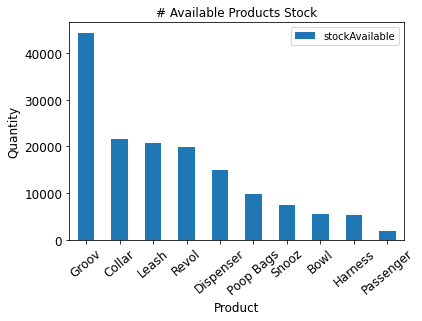

In [40]:
import matplotlib.pyplot as plt

fig1 = summarized_df.head(10).plot(kind = 'bar', x= 'Product Title' , y ='stockAvailable', title ="# Available Products Stock", figsize=(6, 4), legend=True, fontsize=12)

fig1.set_xlabel("Product", fontsize=12)
fig1.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()

In [41]:
summarized_var_df = pd.DataFrame(stock_data1.groupby(['Product Title', 'Variant']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_var_df = summarized_var_df.sort_values(by='stockAvailable', ascending=False)

summarized_var_df.head(5)

,Product Title,Variant,stockAvailable
52,Groov,Groov - Blush,15565.0
55,Groov,Groov - Navy,12607.0
95,Poop Bags,Poop Bags,9703.0
57,Groov,Groov - Turquoise,9384.0
126,Revol,Revol - Medium - Grey,3608.0


In [42]:
#10 product variant which are lowest in stock

# group by products  Bottom 10

summarized_var_df_bottom_10 = pd.DataFrame(stock_data1.groupby(['Product Title', 'Variant']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_var_df_bottom_10 = summarized_var_df_bottom_10.sort_values(by='stockAvailable', ascending=True)

summarized_var_df_bottom_10.head(5)

,Product Title,Variant,stockAvailable
146,Spreadable,Spreadable Treat - Gold N Delicious,-7664.0
98,Refurbished Revol,Refurbished Revol - Medium - Ash,-33.0
102,Refurbished Revol,Refurbished Revol - Small - Ash,-2.0
99,Refurbished Revol,Refurbished Revol - Medium - Charcoal,-1.0
155,V1 Snooz,V1 Snooz - Small - Tan,0.0


In [43]:
# No inventory stock

no_stock_avail_df = summarized_var_df[summarized_var_df["stockAvailable"] == 0]
no_stock_avail_df.head(2) #products which have no inventory

,Product Title,Variant,stockAvailable
132,Revol/Snooz,Revol/Snooz Bundle - Large - Ash,0.0
150,V1 Snooz,V1 Snooz - Medium - Dark Grey,0.0


In [44]:
#####

import pandas as pd
import datetime

s=pd.Timestamp('2023-02-01').normalize()
today=s.strftime("%Y-%m-%d")
print(today)

days_28_period= s - datetime.timedelta(29)
days_28_period=days_28_period.strftime("%Y-%m-%d")
days_28_period


2023-02-01


'2023-01-03'

In [45]:
from pandas import json_normalize
import json
import matplotlib.pyplot as plt
#import requests module
import requests
from requests.auth import HTTPBasicAuth
page=1
sales_data=[]
while(1):
    response = requests.get('https://api.cin7.com/api/v1/SalesOrders?rows=250&where= createdDate<'+str(today)+'T00:00:00Z and createdDate>'+days_28_period+'T23:59:59Z&fields=createdDate,lineItems&page='+str(page),auth = HTTPBasicAuth('DiggsIncUS', '9901f725991a42c4b8ea12917e3c21d9'))
    if not response.json():
        break
    #print (response.json())
    page_data=response.json()
    #separarting each object from the the output array and then appending it sales_Data to have an array of salesrecord objects
    sales_data += page_data
    #end of a single page
    #print("-------------------------------------------------") 
    #increasing the page value to iterate through all pages and get the data
    page+=1 
#print(sales_data)    

In [46]:
df_sales = json_normalize(sales_data)
df_sales=df_sales.explode('lineItems').reset_index(drop=True)
df_sales=df_sales.dropna().reset_index(drop=True)
df_sales['code']=''
df_sales['qty']=''
for i in range(len(df_sales)):
    df_sales.loc[i, "code"]=df_sales.loc[i, "lineItems"]['code']
    df_sales.loc[i, "qty"]=int(df_sales.loc[i, "lineItems"]['qty'])
df_filtered=df_sales.filter(['createdDate','code','qty'], axis=1)
df_filtered.head()

,createdDate,code,qty
0,2023-01-31T23:57:15Z,TRV001AOSG,1
1,2023-01-31T23:56:06Z,PAD018AALG,1
2,2023-01-31T23:56:06Z,GRO010AASIR,1
3,2023-01-31T23:56:06Z,CRA022AALW-1,1
4,2023-01-31T23:56:06Z,CRA022AALW-2,1


In [47]:
#matching the data from sales to the skumapping excel sheet to get product variants and their quantity sold
final_df=pd.merge(stock_data1, df_filtered, on='code', how='left')

#final_df=final_df.groupby("Variant")["qty"].sum()
#final_df=final_df.sort_values(ascending=False)

#final_df= final_df.to_frame()

final_df['createdDate'] = pd.to_datetime(final_df['createdDate']).dt.date

final_df.head(3)

#final_df.to_excel('output1.xlsx') 

,id,status,productId,code,option1,option2,option3,stockAvailable,stockOnHand,Product Title,Variant,Category,Color,Size,Prod_variant,createdDate,qty
0,940,Active,979,TPD001AOSC,,,,0.0,0.0,Passenger,Passenger/Pee Pad Bundle - Charcoal,Travel,Charcoal,NaN,Passenger- Charcoal-,NaT,NaN
1,939,Active,978,WBD001AA4I,,,,0.0,0.0,Poop Bags,Poop Bags 4x Bundle,Walk,NaN,NaN,Poop Bags--,2023-01-31,1
2,939,Active,978,WBD001AA4I,,,,0.0,0.0,Poop Bags,Poop Bags 4x Bundle,Walk,NaN,NaN,Poop Bags--,2023-01-30,1


In [48]:
#summary = df[['stockAvailable', 'qty']].describe()
summary=final_df.groupby(["Product Title","Variant", "stockAvailable", "createdDate"], as_index=False)['qty'].sum().sort_values(by=["Product Title","createdDate"])
#summary=Salevsinvent_df.groupby("Product_Title")['qty'].sum()

#adding sell through rate
summary['Sell_through_rate'] = summary.apply(lambda x: (x['qty']/x['stockAvailable']*100 if x['stockAvailable']!=0 else 0) if x['qty']!=0 else 0, axis=1)
summary.head(3)


,Product Title,Variant,stockAvailable,createdDate,qty,Sell_through_rate
0,Bowl,Crate Bowl I/L Ash,1225.0,2023-01-04,4,0.326531
27,Bowl,Crate Bowl I/L Charcoal,2021.0,2023-01-04,4,0.197922
45,Bowl,Crate Bowl S/M Ash,593.0,2023-01-04,4,0.674536


In [49]:
summary["createdDate"] = pd.to_datetime(summary["createdDate"])
summary.dtypes

Product Title                object
Variant                      object
stockAvailable              float64
createdDate          datetime64[ns]
qty                           int64
Sell_through_rate           float64
dtype: object

In [51]:
summary.to_excel('output_summary.xlsx', engine='xlsxwriter')  

In [52]:
#checking null values
#summary.Sell_through_rate.unique()
#summary.head()
#summary_grpdf = summary.groupby(['createdDate', 'Product Title']).sum('qty')
#summary_grpdf.head(2)

In [94]:
summary.isnull().sum()

Product Title        0
Variant              0
stockAvailable       0
createdDate          0
qty                  0
Sell_through_rate    0
dtype: int64

In [102]:
summary_2=summary.groupby(["Product Title","createdDate"], as_index=False)['qty', "stockAvailable"].sum().sort_values(by=["Product Title","createdDate"])
summary_2.head()


<ipython-input-102-ec4a0e3b7772>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summary_2=summary.groupby(["Product Title","createdDate"], as_index=False)['qty', "stockAvailable"].sum().sort_values(by=["Product Title","createdDate"])


,Product Title,createdDate,qty,stockAvailable
0,Bowl,2023-01-04,13,5508.0
1,Bowl,2023-01-05,6,5508.0
2,Bowl,2023-01-06,8,4283.0
3,Bowl,2023-01-07,2,1225.0
4,Bowl,2023-01-08,7,3246.0


In [107]:
pivot_df = pd.pivot_table(summary_2,index=["createdDate"],values=["qty"], columns=['Product Title'], fill_value=0)

pivot_df.head()

qty                                                             \
Product Title Bowl Bowl + Crate Clip Bowl Clip Collar Dispenser Groov Harness   
createdDate                                                                     
2023-01-04      13                 0         0      7        14    45       4   
2023-01-05       6                 0         1      2        11    42       0   
2023-01-06       8                 0         0      2         4    34       2   
2023-01-07       2                 0         0      5        10    48       2   
2023-01-08       7                 0         0      5        16    39       1   

                                                                               \
Product Title Leash Passenger Pee Pad Pillo Poop Bags Refurbished Revol Revol   
createdDate                                                                     
2023-01-04        5         2       1     4        32                 2   111   
2023-01-05        0         2       2     5        12                 0    88   
2023-01-06        1         1       1     0        17                 3    89   
2023-01-07        2         3       4     4        27                 0   121   
2023-01-08        3         5       3     0        38                 3   105   

                                         
Product Title Snooz Spreadable V1 Snooz  
createdDate                              
2023-01-04       57         38        5  
2023-01-05       66         23        1  
2023-01-06       47         30        2  
2023-01-07       57         28        1  
2023-01-08       56         25        3

In [113]:
#pivot_df.info()
pivot_df.shape

(28, 17)

In [114]:
train=pivot_df[0:18] 
test=pivot_df[18:]

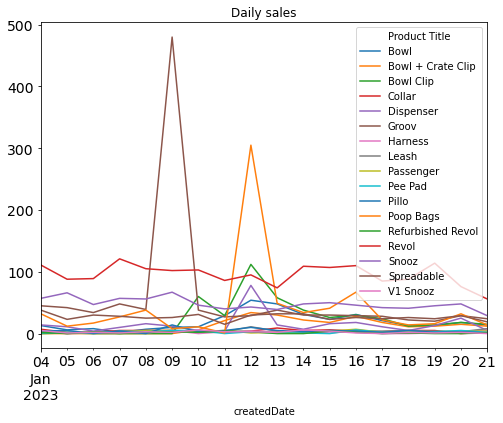

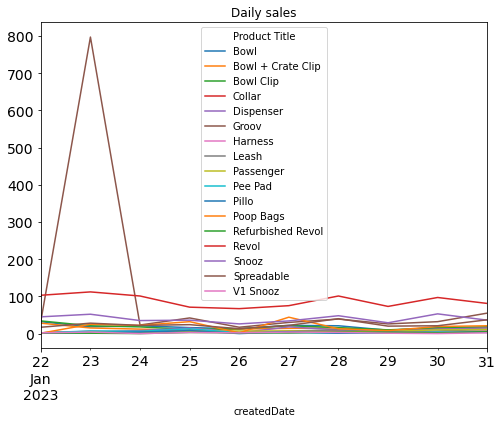

In [117]:
#Plotting data
train.qty.plot(figsize=(8,6), title= 'Daily sales', fontsize=14)
test.qty.plot(figsize=(8,6), title= 'Daily sales', fontsize=14)
plt.show()


In [95]:
# create a dictionary to hold the separate DataFrames
product_dfs = {}

# loop through the unique product titles and create a separate DataFrame for each one
for title in summary["Product Title"].unique():
    product_df = summary[summary["Product Title"] == title].reset_index(drop=True)
    product_dfs[title] = product_df

# access the separate DataFrames by product title
for title, product_df in product_dfs.items():
    print(f"DataFrame for {title}:")
    print(product_df.head())


DataFrame for Bowl:
  Product Title                  Variant  stockAvailable createdDate  qty  \
0          Bowl       Crate Bowl I/L Ash          1225.0  2023-01-04    4   
1          Bowl  Crate Bowl I/L Charcoal          2021.0  2023-01-04    4   
2          Bowl       Crate Bowl S/M Ash           593.0  2023-01-04    4   
3          Bowl  Crate Bowl S/M Charcoal          1669.0  2023-01-04    1   
4          Bowl       Crate Bowl I/L Ash          1225.0  2023-01-05    1   

   Sell_through_rate  
0           0.326531  
1           0.197922  
2           0.674536  
3           0.059916  
4           0.081633  
DataFrame for Bowl + Crate Clip:
       Product Title                    Variant  stockAvailable createdDate  \
0  Bowl + Crate Clip  Crate Bowl + Clip I/L Ash             0.0  2023-01-10   
1  Bowl + Crate Clip  Crate Bowl + Clip S/M Ash             0.0  2023-01-10   
2  Bowl + Crate Clip  Crate Bowl + Clip I/L Ash             0.0  2023-01-11   
3  Bowl + Crate Clip  Crate Bo

In [96]:
bowl_df = product_dfs["Bowl"]
# Sort the dataframe by createdDate
bowl_df = bowl_df.sort_values(by="createdDate")

bowl_df.head(8)

,Product Title,Variant,stockAvailable,createdDate,qty,Sell_through_rate
0,Bowl,Crate Bowl I/L Ash,1225.0,2023-01-04,4,0.326531
1,Bowl,Crate Bowl I/L Charcoal,2021.0,2023-01-04,4,0.197922
2,Bowl,Crate Bowl S/M Ash,593.0,2023-01-04,4,0.674536
3,Bowl,Crate Bowl S/M Charcoal,1669.0,2023-01-04,1,0.059916
4,Bowl,Crate Bowl I/L Ash,1225.0,2023-01-05,1,0.081633
5,Bowl,Crate Bowl I/L Charcoal,2021.0,2023-01-05,1,0.049480
6,Bowl,Crate Bowl S/M Ash,593.0,2023-01-05,3,0.505902
7,Bowl,Crate Bowl S/M Charcoal,1669.0,2023-01-05,1,0.059916


In [121]:
bowl_df2=bowl_df.groupby(["Product Title","createdDate"], as_index=False)['qty', "stockAvailable"].sum().sort_values(by=["Product Title","createdDate"])
bowl_df2.head()



<ipython-input-121-30fb2347f8da>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bowl_df2=bowl_df.groupby(["Product Title","createdDate"], as_index=False)['qty', "stockAvailable"].sum().sort_values(by=["Product Title","createdDate"])


,Product Title,createdDate,qty,stockAvailable
0,Bowl,2023-01-04,13,5508.0
1,Bowl,2023-01-05,6,5508.0
2,Bowl,2023-01-06,8,4283.0
3,Bowl,2023-01-07,2,1225.0
4,Bowl,2023-01-08,7,3246.0


In [123]:
bowl_df2['Rolling window'] = bowl_df2.qty.rolling(window=5).mean().round(0)
#pivoted_df = pd.pivot_table(
#           data    = summary,
#           values  = 'qty',
#           index   = 'createdDate',
#           columns = 'Product Title'       )
#pivoted_df.columns.name = None
#pivoted_df.columns = [f"item_{col}" for col in summary.columns]
#pivoted_df = summary.asfreq('1D')
#pivoted_df = summary.sort_index()
bowl_df2.head(12)


,Product Title,createdDate,qty,stockAvailable,Rolling window
0,Bowl,2023-01-04,13,5508.0,NaN
1,Bowl,2023-01-05,6,5508.0,NaN
2,Bowl,2023-01-06,8,4283.0,NaN
3,Bowl,2023-01-07,2,1225.0,NaN
4,Bowl,2023-01-08,7,3246.0,7.0
5,Bowl,2023-01-09,10,5508.0,7.0
6,Bowl,2023-01-10,11,5508.0,8.0
7,Bowl,2023-01-11,29,5508.0,12.0
8,Bowl,2023-01-12,54,3487.0,22.0
9,Bowl,2023-01-13,48,5508.0,30.0


In [ ]:
#https://www.embedded-robotics.com/forecast-sales-using-machine-learning/
#https://www.cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast.html 


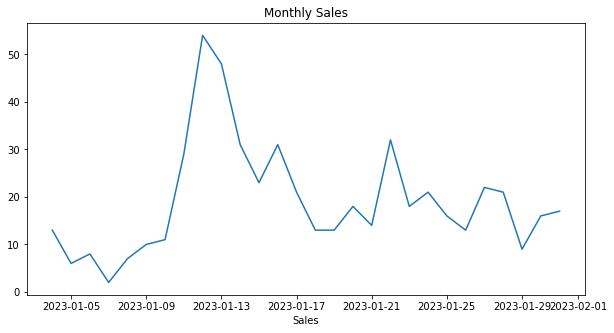

In [61]:
plt.figure(figsize=(10,5))
plt.plot(bowl_df2['createdDate'], bowl_df2['qty'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Sales")
plt.show()

In [62]:
train_data = bowl_df2[:-12]
test_data = bowl_df2[-12:]
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (16, 4)
Test Data Shape: (12, 4)


In [64]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

TypeError: '(slice(None, None, None), slice(1, None, None))' is an invalid key